# 586 RNN Project

* Authors: Harry Sun Yuanlong, Shreeram Murali

* Project overview: predict stock index return using past several day's return

* Data: S&P 500 since 1950-01-03(it is the date when fanance.Yahoo has the volume of trading, but actually SP500 is not officially released until 1957-03-04, mysterious trading volume!)

* variable in the model: percent change of daily return of SP500

----
* Team member Role: 

    Harry Sun:
    
    * coming up with the ideas if different models, using a variety of variables to explore the possibility;
    * collecting code and models running on similar question from online sources;
    * made interpretation of the model, write code, finalize the submission version

    Shreeram:
    * literature review and data collection
    * execution of models, write codes 
    * organize meetings, execution and test code on colab/kaggle
    
----


## Conclusion: 
 

1. We tried different Hyper-parameters of the model, including changing the number of layers, number of neurons, iteration numbers, optimization method, a appropriate model is the easiest one with two layers and 200 neurons. 

2. the result of four differnet micro-layers does not change much since we tried basic RNN, basic LSTM, adjusted LSTM and Gate Recurrent Unit.  
    * Interestingly enough, the MSE of the model does not change much after several not many iterations of the first epoch.
    * it is not hard to understand here: we are only using one variables (time series) to pedict the following day's return, the predictive power really suffers no matter we choose MA(5) or MA(20)( which means using the past five days data or past 20 days data to predict the next). 
    * From the financial market perspective, it is quite understandable: if there is a significant signal that brings extra returns(say the odds of correct is 0.6) only using price returns itself, the equilibrium is not balanced in the long run.  
    * We even tried using the opening/closing of the stock price, which is explosive in the long run, we did the normalization and interestingly the model also quickly converges, which makes us believe that the sheer moving window method is of little use for predicting the price return, the model ceases to learn after only very few samples. 
    * the price of financial index(return) is so comprehensive that it always updates and reflects the new information or data available to investors at that time, regime changes, cyclical patterns,different inflation rate or interest rate even under similar return patterns can not be learnt from only a sequence of one variable.  Generally there are promising directions in this area. 

3. Overview of the result: 

----


| Items  | BasicRNN  | BasicLSTM  | LSTM2  |  GRU |
|---|---|---|---|---|
| MSE_train  | 0.000079  | 0.000080  |  0.000079 |  0.000078 |
| MSE_Development  | 0.000220  |  0.000221 |  0.000214 | 0.000221  |
| Predict_accuracy_train  |  0.49 | 0.54  | 0.47  | 0.53  |
|Predict_accuracy_development| 0.45 | 0.50 | 0.45 |  0.48|
|Predict_accuracy_test| 0.46 |0.50  | 0.46 | 0.47 |

4. Future research: 

    * momentum factors could include other variables, such as trading volume, percent change of volume, etc. 
    * Try other functions of price,such as other technical indicators as auxiliary predictors, or increase the features of input X can also be a direction
    * higher frequency data such as second-level trading patterns may be a little different. 


In [1]:
import os
os.getcwd()
os.chdir('C:\\Users\\DELL\\desktop\\586project')

In [2]:
import numpy as np
import pandas as pd
import math
import sklearn
import sklearn.preprocessing
import datetime
import os
import matplotlib.pyplot as plt
import tensorflow as tf


In [3]:
# Hyper-parameters, Part One: 

valid_set_size_percentage = 10 # same as development set; specifically we split total data as train, validation, test sets.
test_set_size_percentage = 10  # 
seq_len = 5  # moving window size, inother words the MA(n)

In [4]:
import pandas as pd
df=pd.read_csv("sp500.csv", index_col = 0)
df.info()
df.tail()

<class 'pandas.core.frame.DataFrame'>
Index: 17692 entries, 1950-01-04 to 2020-04-27
Data columns (total 7 columns):
open        17692 non-null float64
high        17692 non-null float64
low         17692 non-null float64
close       17692 non-null float64
volume      17692 non-null int64
p_change    17692 non-null float64
v_change    17692 non-null float64
dtypes: float64(6), int64(1)
memory usage: 1.1+ MB


,open,high,low,close,volume,p_change,v_change
date,,,,,,,
2020-04-21,2784.810059,2785.540039,2727.100098,2736.560059,5075830000,-0.030675,-0.027649
2020-04-22,2787.889893,2815.100098,2775.949951,2799.310059,5049660000,0.022930,-0.005156
2020-04-23,2810.419922,2844.899902,2794.260010,2797.800049,5756520000,-0.000539,0.139982
2020-04-24,2812.639893,2842.709961,2791.760010,2836.739990,5374480000,0.013918,-0.066366
2020-04-27,2854.649902,2887.719971,2852.889893,2878.479980,5194260000,0.014714,-0.033533


In [6]:
# in this projet we are not using the normalize function since we only focus on the daily percentagge returns of SP500, which is within range
# of [-0.25,0.15], didn't normalize it. 

def normalize_data(df):
    min_max_scaler = sklearn.preprocessing.MinMaxScaler()
    try:
        
        df['open'] = min_max_scaler.fit_transform(df.open.values.reshape(-1,1))
        df['high'] = min_max_scaler.fit_transform(df.high.values.reshape(-1,1))
        df['low'] = min_max_scaler.fit_transform(df.low.values.reshape(-1,1))
        df['close'] = min_max_scaler.fit_transform(df['close'].values.reshape(-1,1))
        df['p_change'] = min_max_scaler.fit_transform(df['p_change'].values.reshape(-1,1))
        df['volume'] = min_max_scaler.fit_transform(df.volume.values.reshape(-1,1))
        df['v_change'] = min_max_scaler.fit_transform(df['v_change'].values.reshape(-1,1))
    except:
        pass
    
    return df

In [7]:
df2= df.copy()
df2.reset_index(inplace = True)
df2.drop(['date'],1,inplace=True)
df2.drop(['volume'],1,inplace=True)
df2.drop(['v_change'],1,inplace=True)
df2.drop(['open'],1,inplace=True)
df2.drop(['high'],1,inplace=True)
df2.drop(['low'],1,inplace=True)
df2.drop(['close'],1,inplace=True)

,p_change
count,17692.000000
mean,0.000340
std,0.009850
min,-0.204669
25%,-0.004023
50%,0.000477
75%,0.004969
max,0.115800


* split data and pre-processing

In [8]:
def load_data(stock, seq_len):
    
#     data_raw = stock.as_matrix() # convert to numpy array
    data_raw=stock.to_numpy()
    data = []
    
    # create all possible sequences of length seq_len
    for index in range(len(data_raw) - seq_len): 
        data.append(data_raw[index: index + seq_len])
    
    data = np.array(data);
    valid_set_size = int(np.round(valid_set_size_percentage/100*data.shape[0]));  
    test_set_size = int(np.round(test_set_size_percentage/100*data.shape[0]));
    train_set_size = data.shape[0] - (valid_set_size + test_set_size);
    
    x_train = data[:train_set_size,:-1,:]
    y_train = data[:train_set_size,-1,:]
    
    x_valid = data[train_set_size:train_set_size+valid_set_size,:-1,:]
    y_valid = data[train_set_size:train_set_size+valid_set_size,-1,:]
    
    x_test = data[train_set_size+valid_set_size:,:-1,:]
    y_test = data[train_set_size+valid_set_size:,-1,:]
    
    return [x_train, y_train, x_valid, y_valid, x_test, y_test]

In [9]:
x_train, y_train, x_valid, y_valid, x_test, y_test = load_data(df2, seq_len)
print('x_train.shape = ',x_train.shape)
print('y_train.shape = ', y_train.shape)
print('x_valid.shape = ',x_valid.shape)
print('y_valid.shape = ', y_valid.shape)
print('x_test.shape = ', x_test.shape)
print('y_test.shape = ',y_test.shape)

x_train.shape =  (14149, 4, 1)
y_train.shape =  (14149, 1)
x_valid.shape =  (1769, 4, 1)
y_valid.shape =  (1769, 1)
x_test.shape =  (1769, 4, 1)
y_test.shape =  (1769, 1)


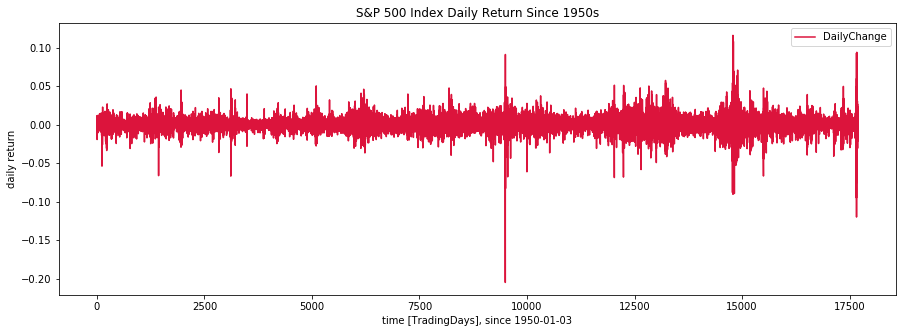

In [14]:
plt.figure(figsize=(15, 5));
# plt.plot(df_norm.open.values, color='purple', label='open')
# plt.plot(df_norm.close.values, color='royalblue', label='close')
# plt.plot(df_norm.low.values, color='blue', label='low')
# plt.plot(df_norm.high.values, color='green', label='high')
plt.plot(df_norm['p_change'].values,color = 'crimson', label = 'DailyChange')
#plt.plot(df_stock_norm.volume.values, color='gray', label='volume')
plt.title('S&P 500 Index Daily Return Since 1950s')
plt.xlabel('time [TradingDays], since 1950-01-03')
plt.ylabel('daily return')
plt.legend(loc='best')
plt.show()

In [11]:
index_in_epoch = 0;
perm_array  = np.arange(x_train.shape[0])
print(perm_array)
a=np.random.shuffle(perm_array)
print(a)

[    0     1     2 ... 14146 14147 14148]
None


In [12]:
def get_next_batch(batch_size):
    global index_in_epoch, x_train, perm_array   
    start = index_in_epoch
    index_in_epoch += batch_size
    
    if index_in_epoch > x_train.shape[0]:
        np.random.shuffle(perm_array) # shuffle permutation array
        start = 0 # start next epoch
        index_in_epoch = batch_size
        
    end = index_in_epoch
    return x_train[perm_array[start:end]], y_train[perm_array[start:end]]

#         np.random.shuffle(perm_array) # shuffle permutation array
#         start = 0 # start next epoch
#         index_in_epoch = batch_size

In [13]:
# Hyper-parameters TWO: 

n_steps = seq_len-1 
n_inputs = x_train.shape[2] # number of input features
n_neurons = 200 
n_outputs = y_train.shape[1] # number of predicted output features values

### Other HYPER
n_layers = 2
learning_rate = 0.001
batch_size = 128  # TBD, originally 50
n_epochs = 100 
train_set_size = x_train.shape[0]
test_set_size = x_test.shape[0]


In [ ]:
# Not using this, can be better structured if more time allowed. 
def output_layer(tp):
    if tp == "basicRNN":
        layers = [tf.compat.v1.nn.rnn_cell.BasicRNNCell(num_units=n_neurons, activation=tf.nn.elu)
          for layer in range(n_layers)]
    elif tp =="basicLSTM":
        layers = [tf.compat.v1.nn.rnn_cell.BasicLSTMCell(num_units=n_neurons, activation=tf.nn.elu)
         for layer in range(n_layers)]
    elif tp == "LSTMpeephole":
        layers = [tf.compat.v1.nn.rnn_cell.LSTMCell(num_units=n_neurons, activation=tf.nn.leaky_relu, use_peepholes = True)
         for layer in range(n_layers)]
    elif tp == "GRU":
        layers = [tf.compat.v1.nn.rnn_cell.GRUCell(num_units=n_neurons, activation=tf.nn.leaky_relu)
         for layer in range(n_layers)]
    return layers

# 1. Basic RNN Result

Instructions for updating:
This class is equivalent as tf.keras.layers.SimpleRNNCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
This class is equivalent as tf.keras.layers.StackedRNNCells, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Please use `layer.add_weight` method instead.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use keras.layers.Dense instead.
Instructions for updating:
Please use `layer.__call__` method instead.
0.00 epochs: MSE train/valid = 0.003216/0.003364
4.99 epochs: MSE train/valid = 0.000080/0.000223
9.99 epochs: MSE train/valid = 0.000080/0.000218
14.98 epochs: MSE train/valid = 0.000080/0.000223
19.97 epochs: MSE train/valid = 0.0

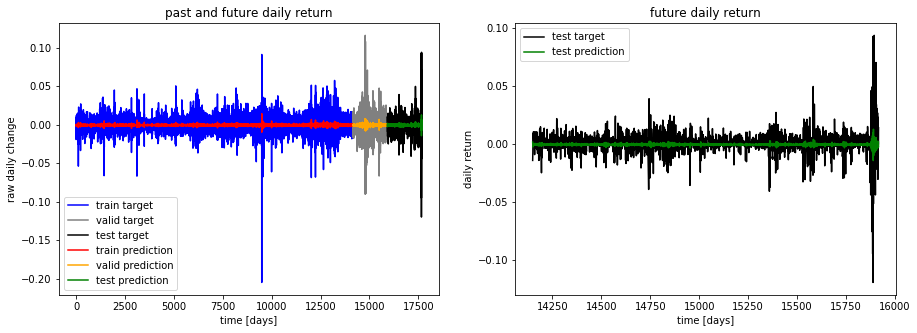

In [15]:

tf.compat.v1.reset_default_graph()
tf.compat.v1.disable_eager_execution()

X = tf.compat.v1.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.compat.v1.placeholder(tf.float32, [None, n_outputs])

# use Basic RNN Cell
layers = [tf.compat.v1.nn.rnn_cell.BasicRNNCell(num_units=n_neurons, activation=tf.nn.elu)
          for layer in range(n_layers)]    # mse: 0.000080/0.000222

                                                                     
multi_layer_cell = tf.compat.v1.nn.rnn_cell.MultiRNNCell(layers)
rnn_outputs, states = tf.compat.v1.nn.dynamic_rnn(multi_layer_cell, X, dtype=tf.float32)

stacked_rnn_outputs = tf.reshape(rnn_outputs, [-1, n_neurons]) 
stacked_outputs = tf.compat.v1.layers.dense(stacked_rnn_outputs, n_outputs)
outputs = tf.reshape(stacked_outputs, [-1, n_steps, n_outputs])
outputs = outputs[:,n_steps-1,:] # keep only last output of sequence
                                              
loss = tf.reduce_mean(input_tensor=tf.square(outputs - y)) # loss function = mean squared error 
optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=learning_rate) 
training_op = optimizer.minimize(loss)
                                              
# run graph########

with tf.compat.v1.Session() as sess: 
    sess.run(tf.compat.v1.global_variables_initializer())
    for iteration in range(int(n_epochs*train_set_size/batch_size)):
        x_batch, y_batch = get_next_batch(batch_size) # fetch the next training batch 
        sess.run(training_op, feed_dict={X: x_batch, y: y_batch}) 
        if iteration % int(5*train_set_size/batch_size) == 0:
            mse_train = loss.eval(feed_dict={X: x_train, y: y_train}) 
            mse_valid = loss.eval(feed_dict={X: x_valid, y: y_valid}) 
            print('%.2f epochs: MSE train/valid = %.6f/%.6f'%(
                iteration*batch_size/train_set_size, mse_train, mse_valid))
            
            
    y_train_pred = sess.run(outputs, feed_dict={X: x_train})
    y_valid_pred = sess.run(outputs, feed_dict={X: x_valid})
    y_test_pred = sess.run(outputs, feed_dict={X: x_test})
    


    
ft = 0 

## show predictions
plt.figure(figsize=(15, 5));
plt.subplot(1,2,1);

plt.plot(np.arange(y_train.shape[0]), y_train[:,ft], color='blue', label='train target')

plt.plot(np.arange(y_train.shape[0], y_train.shape[0]+y_valid.shape[0]), y_valid[:,ft],
         color='gray', label='valid target')

plt.plot(np.arange(y_train.shape[0]+y_valid.shape[0],
                   y_train.shape[0]+y_test.shape[0]+y_test.shape[0]),
         y_test[:,ft], color='black', label='test target')

plt.plot(np.arange(y_train_pred.shape[0]),y_train_pred[:,ft], color='red',
         label='train prediction')

plt.plot(np.arange(y_train_pred.shape[0], y_train_pred.shape[0]+y_valid_pred.shape[0]),
         y_valid_pred[:,ft], color='orange', label='valid prediction')

plt.plot(np.arange(y_train_pred.shape[0]+y_valid_pred.shape[0],
                   y_train_pred.shape[0]+y_valid_pred.shape[0]+y_test_pred.shape[0]),
         y_test_pred[:,ft], color='green', label='test prediction')

plt.title('past and future daily return')
plt.xlabel('time [days]')
plt.ylabel('raw daily change')
plt.legend(loc='best');

plt.subplot(1,2,2);

plt.plot(np.arange(y_train.shape[0], y_train.shape[0]+y_test.shape[0]),
         y_test[:,ft], color='black', label='test target')

plt.plot(np.arange(y_train_pred.shape[0], y_train_pred.shape[0]+y_test_pred.shape[0]),
         y_test_pred[:,ft], color='green', label='test prediction')

plt.title('future daily return')
plt.xlabel('time [days]')
plt.ylabel('daily return')
plt.legend(loc='best');

corr_price_development_train = np.sum(np.equal(np.sign(y_train[:,0]),np.sign(y_train_pred[:,0])).astype(int)) / y_train.shape[0]
corr_price_development_valid = np.sum(np.equal(np.sign(y_valid[:,0]),np.sign(y_valid_pred[:,0])).astype(int))/ y_valid.shape[0]
corr_price_development_test = np.sum(np.equal(np.sign(y_test[:,0]),np.sign(y_test_pred[:,0])).astype(int)) / y_test.shape[0]

print('correct sign prediction for price percentage change for train/valid/test: %.2f/%.2f/%.2f'%(
    corr_price_development_train, corr_price_development_valid, corr_price_development_test))


# 2 Basic LSTM Result

Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
0.00 epochs: MSE train/valid = 0.000337/0.000478
4.99 epochs: MSE train/valid = 0.000080/0.000219
9.99 epochs: MSE train/valid = 0.000081/0.000220
14.98 epochs: MSE train/valid = 0.000081/0.000223
19.97 epochs: MSE train/valid = 0.000079/0.000221
24.97 epochs: MSE train/valid = 0.000079/0.000220
29.96 epochs: MSE train/valid = 0.000079/0.000220
34.96 epochs: MSE train/valid = 0.000079/0.000221
39.95 epochs: MSE train/valid = 0.000079/0.000220
44.94 epochs: MSE train/valid = 0.000079/0.000220
49.94 epochs: MSE train/valid = 0.000080/0.000221
54.93 epochs: MSE train/valid = 0.000079/0.000221
59.92 epochs: MSE train/valid = 0.000079/0.000219
64.92 epochs: MSE train/valid = 0.000079/0.000220
69.91 epochs: MSE train/valid = 0.000080/0.000221
74.91 epochs: MSE train/valid = 0.000079/0.000220
79.90 epochs: MSE train/valid = 0.000080/0.000221
84.89 epochs: MSE train/

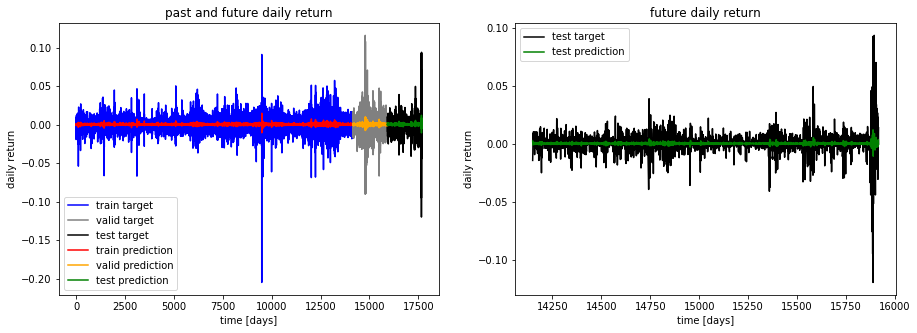

In [16]:

tf.compat.v1.reset_default_graph()
tf.compat.v1.disable_eager_execution()

X = tf.compat.v1.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.compat.v1.placeholder(tf.float32, [None, n_outputs])


# use Basic LSTM Cell 
layers = [tf.compat.v1.nn.rnn_cell.BasicLSTMCell(num_units=n_neurons, activation=tf.nn.elu)
         for layer in range(n_layers)]
                                                                     
multi_layer_cell = tf.compat.v1.nn.rnn_cell.MultiRNNCell(layers)
rnn_outputs, states = tf.compat.v1.nn.dynamic_rnn(multi_layer_cell, X, dtype=tf.float32)

stacked_rnn_outputs = tf.reshape(rnn_outputs, [-1, n_neurons]) 
stacked_outputs = tf.compat.v1.layers.dense(stacked_rnn_outputs, n_outputs)
outputs = tf.reshape(stacked_outputs, [-1, n_steps, n_outputs])
outputs = outputs[:,n_steps-1,:] # keep only last output of sequence
                                              
loss = tf.reduce_mean(input_tensor=tf.square(outputs - y)) # loss function = mean squared error 
optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=learning_rate) 
training_op = optimizer.minimize(loss)
                                              
# run graph########

with tf.compat.v1.Session() as sess: 
    sess.run(tf.compat.v1.global_variables_initializer())
    for iteration in range(int(n_epochs*train_set_size/batch_size)):
        x_batch, y_batch = get_next_batch(batch_size) # fetch the next training batch 
        sess.run(training_op, feed_dict={X: x_batch, y: y_batch}) 
        if iteration % int(5*train_set_size/batch_size) == 0:
            mse_train = loss.eval(feed_dict={X: x_train, y: y_train}) 
            mse_valid = loss.eval(feed_dict={X: x_valid, y: y_valid}) 
            print('%.2f epochs: MSE train/valid = %.6f/%.6f'%(
                iteration*batch_size/train_set_size, mse_train, mse_valid))
            
            
    y_train_pred = sess.run(outputs, feed_dict={X: x_train})
    y_valid_pred = sess.run(outputs, feed_dict={X: x_valid})
    y_test_pred = sess.run(outputs, feed_dict={X: x_test})
    


    
ft = 0 

## show predictions
plt.figure(figsize=(15, 5));
plt.subplot(1,2,1);

plt.plot(np.arange(y_train.shape[0]), y_train[:,ft], color='blue', label='train target')

plt.plot(np.arange(y_train.shape[0], y_train.shape[0]+y_valid.shape[0]), y_valid[:,ft],
         color='gray', label='valid target')

plt.plot(np.arange(y_train.shape[0]+y_valid.shape[0],
                   y_train.shape[0]+y_test.shape[0]+y_test.shape[0]),
         y_test[:,ft], color='black', label='test target')

plt.plot(np.arange(y_train_pred.shape[0]),y_train_pred[:,ft], color='red',
         label='train prediction')

plt.plot(np.arange(y_train_pred.shape[0], y_train_pred.shape[0]+y_valid_pred.shape[0]),
         y_valid_pred[:,ft], color='orange', label='valid prediction')

plt.plot(np.arange(y_train_pred.shape[0]+y_valid_pred.shape[0],
                   y_train_pred.shape[0]+y_valid_pred.shape[0]+y_test_pred.shape[0]),
         y_test_pred[:,ft], color='green', label='test prediction')

plt.title('past and future daily return')
plt.xlabel('time [days]')
plt.ylabel('daily return')
plt.legend(loc='best');

plt.subplot(1,2,2);

plt.plot(np.arange(y_train.shape[0], y_train.shape[0]+y_test.shape[0]),
         y_test[:,ft], color='black', label='test target')

plt.plot(np.arange(y_train_pred.shape[0], y_train_pred.shape[0]+y_test_pred.shape[0]),
         y_test_pred[:,ft], color='green', label='test prediction')

plt.title('future daily return')
plt.xlabel('time [days]')
plt.ylabel('daily return')
plt.legend(loc='best');

corr_price_development_train = np.sum(np.equal(np.sign(y_train[:,0]),
            np.sign(y_train_pred[:,0])).astype(int)) / y_train.shape[0]
corr_price_development_valid = np.sum(np.equal(np.sign(y_valid[:,0]),
            np.sign(y_valid_pred[:,0])).astype(int)) / y_valid.shape[0]
corr_price_development_test = np.sum(np.equal(np.sign(y_test[:,0]),
            np.sign(y_test_pred[:,0])).astype(int)) / y_test.shape[0]

print('correct sign prediction for daily return for train/valid/test: %.2f/%.2f/%.2f'%(
    corr_price_development_train, corr_price_development_valid, corr_price_development_test))


# 3 LSTM Cell with peephole connections

Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
0.00 epochs: MSE train/valid = 0.000093/0.000229
4.99 epochs: MSE train/valid = 0.000080/0.000216
9.99 epochs: MSE train/valid = 0.000080/0.000217
14.98 epochs: MSE train/valid = 0.000080/0.000216
19.97 epochs: MSE train/valid = 0.000080/0.000216
24.97 epochs: MSE train/valid = 0.000082/0.000218
29.96 epochs: MSE train/valid = 0.000080/0.000216
34.96 epochs: MSE train/valid = 0.000080/0.000216
39.95 epochs: MSE train/valid = 0.000080/0.000216
44.94 epochs: MSE train/valid = 0.000085/0.000221
49.94 epochs: MSE train/valid = 0.000081/0.000217
54.93 epochs: MSE train/valid = 0.000080/0.000216
59.92 epochs: MSE train/valid = 0.000080/0.000216
64.92 epochs: MSE train/valid = 0.000079/0.000216
69.91 epochs: MSE train/valid = 0.000079/0.000216
74.91 epochs: MSE train/valid = 0.000081/0.000217
79.90 epochs: MSE train/valid = 0.000079/0.000215
84.89 epochs: MSE train/

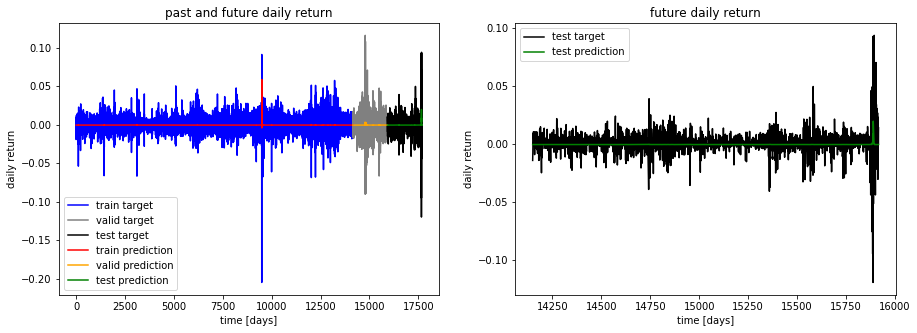

In [17]:

tf.compat.v1.reset_default_graph()
tf.compat.v1.disable_eager_execution()

X = tf.compat.v1.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.compat.v1.placeholder(tf.float32, [None, n_outputs])

# use LSTM Cell with peephole connections
layers = [tf.compat.v1.nn.rnn_cell.LSTMCell(num_units=n_neurons, activation=tf.nn.leaky_relu, use_peepholes = True)
         for layer in range(n_layers)]
                                                                     
multi_layer_cell = tf.compat.v1.nn.rnn_cell.MultiRNNCell(layers)
rnn_outputs, states = tf.compat.v1.nn.dynamic_rnn(multi_layer_cell, X, dtype=tf.float32)

stacked_rnn_outputs = tf.reshape(rnn_outputs, [-1, n_neurons]) 
stacked_outputs = tf.compat.v1.layers.dense(stacked_rnn_outputs, n_outputs)
outputs = tf.reshape(stacked_outputs, [-1, n_steps, n_outputs])
outputs = outputs[:,n_steps-1,:] # keep only last output of sequence
                                              
loss = tf.reduce_mean(input_tensor=tf.square(outputs - y)) # loss function = mean squared error 
optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=learning_rate) 
training_op = optimizer.minimize(loss)
                                              
# run graph########

with tf.compat.v1.Session() as sess: 
    sess.run(tf.compat.v1.global_variables_initializer())
    for iteration in range(int(n_epochs*train_set_size/batch_size)):
        x_batch, y_batch = get_next_batch(batch_size) # fetch the next training batch 
        sess.run(training_op, feed_dict={X: x_batch, y: y_batch}) 
        if iteration % int(5*train_set_size/batch_size) == 0:
            mse_train = loss.eval(feed_dict={X: x_train, y: y_train}) 
            mse_valid = loss.eval(feed_dict={X: x_valid, y: y_valid}) 
            print('%.2f epochs: MSE train/valid = %.6f/%.6f'%(
                iteration*batch_size/train_set_size, mse_train, mse_valid))
            
            
    y_train_pred = sess.run(outputs, feed_dict={X: x_train})
    y_valid_pred = sess.run(outputs, feed_dict={X: x_valid})
    y_test_pred = sess.run(outputs, feed_dict={X: x_test})
    


    
ft = 0 

## show predictions
plt.figure(figsize=(15, 5));
plt.subplot(1,2,1);

plt.plot(np.arange(y_train.shape[0]), y_train[:,ft], color='blue', label='train target')

plt.plot(np.arange(y_train.shape[0], y_train.shape[0]+y_valid.shape[0]), y_valid[:,ft],
         color='gray', label='valid target')

plt.plot(np.arange(y_train.shape[0]+y_valid.shape[0],
                   y_train.shape[0]+y_test.shape[0]+y_test.shape[0]),
         y_test[:,ft], color='black', label='test target')

plt.plot(np.arange(y_train_pred.shape[0]),y_train_pred[:,ft], color='red',
         label='train prediction')

plt.plot(np.arange(y_train_pred.shape[0], y_train_pred.shape[0]+y_valid_pred.shape[0]),
         y_valid_pred[:,ft], color='orange', label='valid prediction')

plt.plot(np.arange(y_train_pred.shape[0]+y_valid_pred.shape[0],
                   y_train_pred.shape[0]+y_valid_pred.shape[0]+y_test_pred.shape[0]),
         y_test_pred[:,ft], color='green', label='test prediction')

plt.title('past and future daily return')
plt.xlabel('time [days]')
plt.ylabel('daily return')
plt.legend(loc='best');

plt.subplot(1,2,2);

plt.plot(np.arange(y_train.shape[0], y_train.shape[0]+y_test.shape[0]),
         y_test[:,ft], color='black', label='test target')

plt.plot(np.arange(y_train_pred.shape[0], y_train_pred.shape[0]+y_test_pred.shape[0]),
         y_test_pred[:,ft], color='green', label='test prediction')

plt.title('future daily return')
plt.xlabel('time [days]')
plt.ylabel('daily return')
plt.legend(loc='best');

corr_price_development_train = np.sum(np.equal(np.sign(y_train[:,0]),
            np.sign(y_train_pred[:,0])).astype(int)) / y_train.shape[0]
corr_price_development_valid = np.sum(np.equal(np.sign(y_valid[:,0]),
            np.sign(y_valid_pred[:,0])).astype(int)) / y_valid.shape[0]
corr_price_development_test = np.sum(np.equal(np.sign(y_test[:,0]),
            np.sign(y_test_pred[:,0])).astype(int)) / y_test.shape[0]

print('correct sign prediction for daily return for train/valid/test: %.2f/%.2f/%.2f'%(
    corr_price_development_train, corr_price_development_valid, corr_price_development_test))


# 4 GRU

Instructions for updating:
This class is equivalent as tf.keras.layers.GRUCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
0.00 epochs: MSE train/valid = 0.000190/0.000324
4.99 epochs: MSE train/valid = 0.000081/0.000217
9.99 epochs: MSE train/valid = 0.000081/0.000217
14.98 epochs: MSE train/valid = 0.000080/0.000216
19.97 epochs: MSE train/valid = 0.000080/0.000216
24.97 epochs: MSE train/valid = 0.000080/0.000215
29.96 epochs: MSE train/valid = 0.000079/0.000217
34.96 epochs: MSE train/valid = 0.000078/0.000220
39.95 epochs: MSE train/valid = 0.000079/0.000220
44.94 epochs: MSE train/valid = 0.000078/0.000221
49.94 epochs: MSE train/valid = 0.000079/0.000219
54.93 epochs: MSE train/valid = 0.000079/0.000221
59.92 epochs: MSE train/valid = 0.000079/0.000220
64.92 epochs: MSE train/valid = 0.000079/0.000221
69.91 epochs: MSE train/valid = 0.000078/0.000220
74.91 e

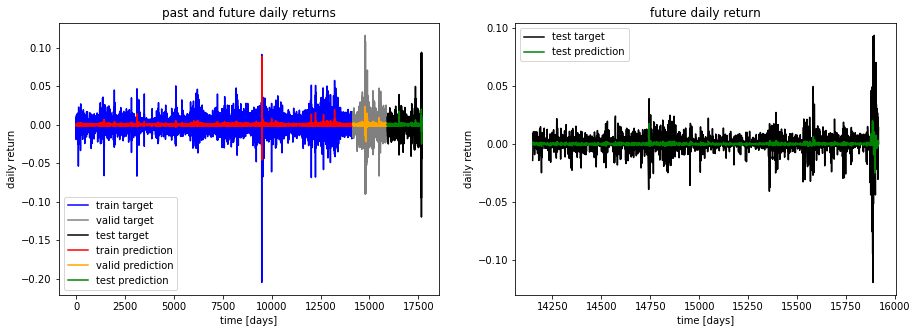

In [18]:

tf.compat.v1.reset_default_graph()
tf.compat.v1.disable_eager_execution()

X = tf.compat.v1.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.compat.v1.placeholder(tf.float32, [None, n_outputs])

# use GRU cell
layers = [tf.compat.v1.nn.rnn_cell.GRUCell(num_units=n_neurons, activation=tf.nn.leaky_relu)
         for layer in range(n_layers)]
                                                                     
multi_layer_cell = tf.compat.v1.nn.rnn_cell.MultiRNNCell(layers)
rnn_outputs, states = tf.compat.v1.nn.dynamic_rnn(multi_layer_cell, X, dtype=tf.float32)

stacked_rnn_outputs = tf.reshape(rnn_outputs, [-1, n_neurons]) 
stacked_outputs = tf.compat.v1.layers.dense(stacked_rnn_outputs, n_outputs)
outputs = tf.reshape(stacked_outputs, [-1, n_steps, n_outputs])
outputs = outputs[:,n_steps-1,:] # keep only last output of sequence
                                              
loss = tf.reduce_mean(input_tensor=tf.square(outputs - y)) # loss function = mean squared error 
optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=learning_rate) 
training_op = optimizer.minimize(loss)
                                              
# run graph########

with tf.compat.v1.Session() as sess: 
    sess.run(tf.compat.v1.global_variables_initializer())
    for iteration in range(int(n_epochs*train_set_size/batch_size)):
        x_batch, y_batch = get_next_batch(batch_size) # fetch the next training batch 
        sess.run(training_op, feed_dict={X: x_batch, y: y_batch}) 
        if iteration % int(5*train_set_size/batch_size) == 0:
            mse_train = loss.eval(feed_dict={X: x_train, y: y_train}) 
            mse_valid = loss.eval(feed_dict={X: x_valid, y: y_valid}) 
            print('%.2f epochs: MSE train/valid = %.6f/%.6f'%(
                iteration*batch_size/train_set_size, mse_train, mse_valid))
            
            
    y_train_pred = sess.run(outputs, feed_dict={X: x_train})
    y_valid_pred = sess.run(outputs, feed_dict={X: x_valid})
    y_test_pred = sess.run(outputs, feed_dict={X: x_test})
    


    
ft = 0 

## show predictions
plt.figure(figsize=(15, 5));
plt.subplot(1,2,1);

plt.plot(np.arange(y_train.shape[0]), y_train[:,ft], color='blue', label='train target')

plt.plot(np.arange(y_train.shape[0], y_train.shape[0]+y_valid.shape[0]), y_valid[:,ft],
         color='gray', label='valid target')

plt.plot(np.arange(y_train.shape[0]+y_valid.shape[0],
                   y_train.shape[0]+y_test.shape[0]+y_test.shape[0]),
         y_test[:,ft], color='black', label='test target')

plt.plot(np.arange(y_train_pred.shape[0]),y_train_pred[:,ft], color='red',
         label='train prediction')

plt.plot(np.arange(y_train_pred.shape[0], y_train_pred.shape[0]+y_valid_pred.shape[0]),
         y_valid_pred[:,ft], color='orange', label='valid prediction')

plt.plot(np.arange(y_train_pred.shape[0]+y_valid_pred.shape[0],
                   y_train_pred.shape[0]+y_valid_pred.shape[0]+y_test_pred.shape[0]),
         y_test_pred[:,ft], color='green', label='test prediction')

plt.title('past and future daily returns')
plt.xlabel('time [days]')
plt.ylabel('daily return')
plt.legend(loc='best');

plt.subplot(1,2,2);

plt.plot(np.arange(y_train.shape[0], y_train.shape[0]+y_test.shape[0]),
         y_test[:,ft], color='black', label='test target')

plt.plot(np.arange(y_train_pred.shape[0], y_train_pred.shape[0]+y_test_pred.shape[0]),
         y_test_pred[:,ft], color='green', label='test prediction')

plt.title('future daily return')
plt.xlabel('time [days]')
plt.ylabel('daily return')
plt.legend(loc='best');

corr_price_development_train = np.sum(np.equal(np.sign(y_train[:,0]),
            np.sign(y_train_pred[:,0])).astype(int)) / y_train.shape[0]
corr_price_development_valid = np.sum(np.equal(np.sign(y_valid[:,0]),
            np.sign(y_valid_pred[:,0])).astype(int)) / y_valid.shape[0]
corr_price_development_test = np.sum(np.equal(np.sign(y_test[:,0]),
            np.sign(y_test_pred[:,0])).astype(int)) / y_test.shape[0]

print('correct sign prediction for daily return for train/valid/test: %.2f/%.2f/%.2f'%(
    corr_price_development_train, corr_price_development_valid, corr_price_development_test))


# Conclusion: 

1. We tried different Hyper-parameters of the model, including changing the number of layers, number of neurons, iteration numbers, optimization method, a appropriate model is the easiest one with two layers and 200 neurons. 

2. the result of four differnet micro-layers does not change much since we tried basic RNN, basic LSTM, adjusted LSTM and Gate Recurrent Unit.  Interestingly enough, the MSE of the model does not change much after several not many iterations of the first epoch, it is not hard to understand here: we are only using one variables (time series) to pedict the following day's return, the predictive power really suffers no matter we choose MA(5) or MA(20)( which means using the past five days data or past 20 days data to predict the next). From the financial market perspective, it is quite understandable: if there is a significant signal that brings extra returns(say the odds of correct is 0.6) only using price returns itself, the equilibrium is not balanced in the long run.  

3. Overview of the result: 

----


| Items  | BasicRNN  | BasicLSTM  | LSTM2  |  GRU |
|---|---|---|---|---|
| MSE_train  | 0.000079  | 0.000080  |  0.000079 |  0.000078 |
| MSE_Development  | 0.000220  |  0.000221 |  0.000214 | 0.000221  |
| Predict_accuracy_train  |  0.49 | 0.54  | 0.47  | 0.53  |
|Predict_accuracy_development| 0.45 | 0.50 | 0.45 |  0.48|
|Predict_accuracy_test| 0.46 |0.50  | 0.46 | 0.47 |

4. Future research: 

    * momentum factors could include other variables, such as trading volume, percent change of volume, etc. 
    * Try other functions of price,such as other technical indicators as auxiliary predictors, or increase the features of input X can also be a direction
